In [1]:
%run ../scripts/notebook_settings.py
import sgkit as sg
import xarray as xr
import glob

In [2]:
# Loading in the kuderna mutation data and new metadata

kuderna_data = pd.read_csv("../data/science.abn7829_data_s2.csv")
# I pick out the following columns
col_species_mut = ['SPECIES_BINOMIAL', 'GENUS', 'SPECIES', 'FAMILY', 'GENERATION_LENGTH', 'MU_PER_GENERATION',
       'MU_PER_YEAR', 'EFFECTIVE_POP_SIZE']
df_species_mut = kuderna_data[col_species_mut]

metadata_dir = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/"
metadata_dirs = glob.glob(metadata_dir+"*_individuals.txt")

df_l = []
for d in metadata_dirs:
    # Identify IDs
    dir_metadata = pd.read_csv(d, sep="\t")
    df_l.append(dir_metadata)
all_inds = pd.concat(df_l)

In [3]:
# Files used
glob.glob("../steps/cobraa/*/aut_D50_ts4_te40*")

['../steps/cobraa/SAMEA2446072/aut_D50_ts4_te40_final_parameters.txt',
 '../steps/cobraa/SAMEA112483168/aut_D50_ts4_te40_final_parameters.txt',
 '../steps/cobraa/SAMEA112483237/aut_D50_ts4_te40_final_parameters.txt',
 '../steps/cobraa/SAMEA3939558/aut_D50_ts4_te40_final_parameters.txt']

In [4]:
# But this investigation will only use individuals from the following geni
metadata_dirs = ['/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/Gorilla_individuals.txt',
                 '/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/Papio_individuals.txt',
                 '/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/Cercopithecus_individuals.txt']

ind_list = [x.split("/")[3] for x in glob.glob("../steps/cobraa/*/aut_D50_ts4_te40*")]
ind_list

['SAMEA2446072', 'SAMEA112483168', 'SAMEA112483237', 'SAMEA3939558']

In [5]:
def get_gamma_from_file(file):
    lines = !cat {file}
    return float([i for i in lines if 'gamma' in i][0].split(' ')[-1])
    
def get_LL_from_file(filename):
    with open(filename) as f:
        lines = f.readlines()
    return float([i for i in lines if 'likelihood' in i and 'final' in i][0].split(' ')[-1])

Gorilla_gorilla_ssp
SAMEA2446072 -19482594.971031114 2311.8692664429545
Gorilla_beringei_ssp


FileNotFoundError: [Errno 2] No such file or directory: '../steps/cobraa/SAMEA3939558/aut_D50_ts16_te22_final_parameters.txt'

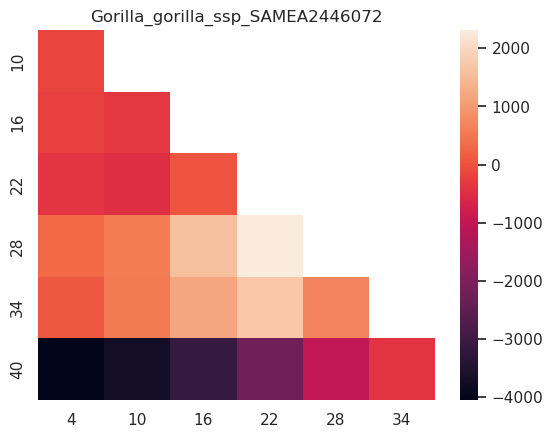

<Figure size 640x480 with 0 Axes>

In [6]:
for d in metadata_dirs:
    # Identify IDs
    dir_metadata = pd.read_csv(d, sep="\t")
    dir_metadata["gss"] = dir_metadata.GENUS+"_"+dir_metadata.SPECIES+"_"+dir_metadata.SUBSPECIES
    short_species = d.split("/")[-1].split("_")[0]
    female_df = dir_metadata[pd.to_numeric(dir_metadata['AVG_COVERAGE_X'], errors='coerce').notnull()]
    female_df = female_df.loc[(female_df.GENETIC_SEX == "F") & (female_df.AVG_COVERAGE_A >= 10)].sort_values(by="AVG_COVERAGE_A", ascending=False)
    sorted_df = female_df
    # Go through every unique genotype calling set.
    for gvcf_folder in sorted_df.GVCF_FOLDER.unique():
        print(gvcf_folder)
        # Pick all inds that are present in the cobraa analysis.
        species_df = sorted_df.loc[sorted_df.GVCF_ID.isin(ind_list) & (sorted_df.GVCF_FOLDER == gvcf_folder)]
        for ind in species_df.GVCF_ID:
            final_params_file_pan = f'../steps/cobraa/{ind}/aut_final_parameters.txt'
            pan_LL = get_LL_from_file(final_params_file_pan)
            matrix_LL_diffs = np.zeros(shape=(6,6))
            matrix_LL_diffs[:] = np.nan
            for te in range(10, 42, 6):
                for ts in range(4, te-4, 6):
                    final_params_file_struct = f'../steps/cobraa/{ind}/aut_D50_ts{ts}_te{te}_final_parameters.txt'
                    struct_LL = get_LL_from_file(final_params_file_struct)
                    diff_LL = struct_LL - pan_LL
                    matrix_LL_diffs[int((te-6)/6),int(ts/6)] = diff_LL
            matrix_LL_diffs = matrix_LL_diffs
            print(ind, pan_LL, np.nanmax(matrix_LL_diffs))
            g = sns.heatmap(matrix_LL_diffs)
            g.set(xticklabels=list(range(4, te-4, 6)), yticklabels=list(range(10, 42, 6)),title=gvcf_folder+"_"+ind)
            plt.figure()